<a href="https://colab.research.google.com/github/yuvi-636/.Deepfake/blob/main/lineGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving WhatsApp Video 2024-10-17 at 11.54.38_70e76838.mp4 to WhatsApp Video 2024-10-17 at 11.54.38_70e76838 (5).mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


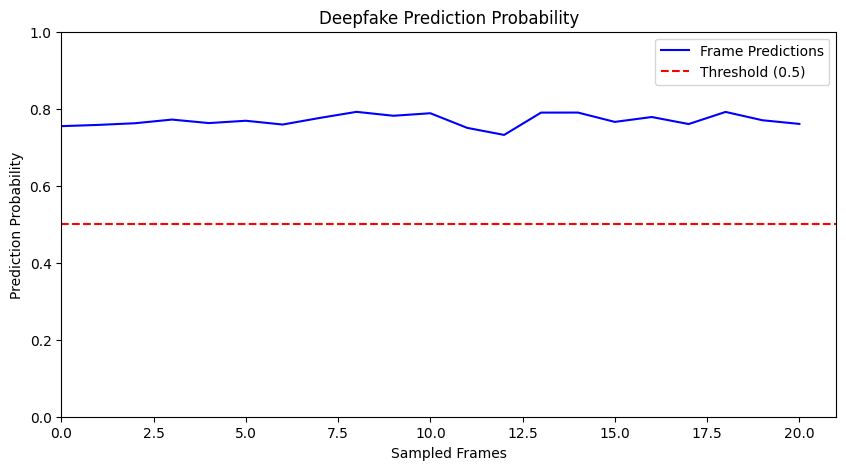

The model predicted the file is a deepfake with a probability of: 0.77
Was the prediction correct? (yes/no): yes
No feedback data to retrain the model.


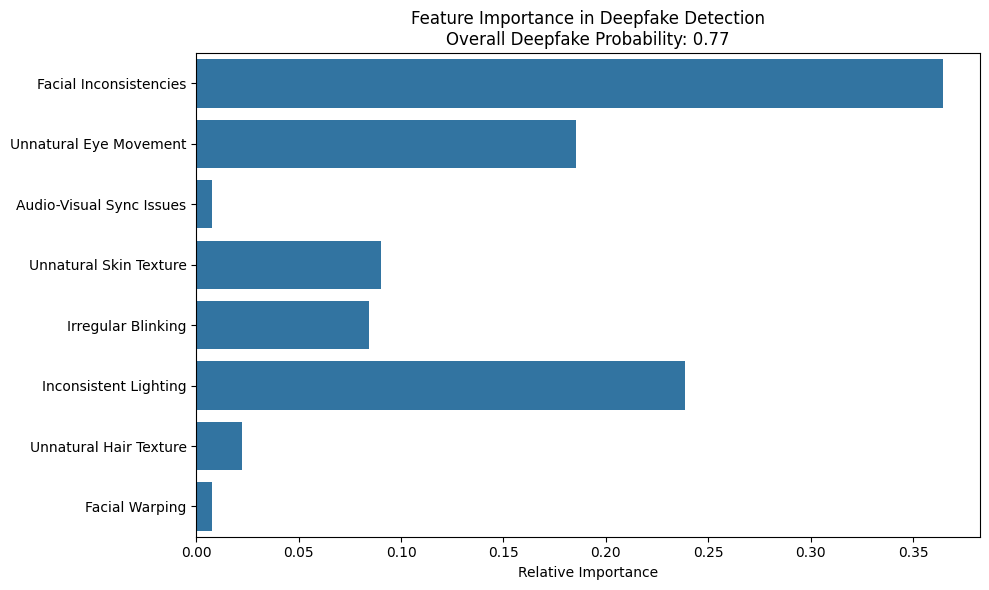

In [44]:
# Cell 1: Install required libraries
!pip install opencv-python-headless librosa matplotlib seaborn scikit-learn tensorflow

# Cell 2: Import libraries
import cv2
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import hashlib

# Initialize set to store file hashes and their predictions
uploaded_files_hashes = {}
feedback_data = []  # Store inputs and correct labels for retraining

# Cell 3: Define preprocessing functions
def preprocess_video(video_path, num_frames=20):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(frame_count // num_frames, 1)  # Sample evenly spaced frames

    for i in range(0, frame_count, frame_interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) / 255.0  # Normalize pixel values
        frames.append(frame)

    cap.release()
    return np.array(frames)

def preprocess_audio(audio_path):
    y, sr = librosa.load(audio_path)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = cv2.resize(mel_spec_db, (224, 224))
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
    return mel_spec_db

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224)) / 255.0  # Normalize pixel values
    return image

# Cell 4: Define model architecture
def build_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-4]:  # Fine-tune the last 4 layers
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Cell 5: Training function with callbacks
def train_model(model, X_train, y_train, epochs=20, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stopping, reduce_lr])
    return history

# Cell 6: Prediction function
def predict(model, input_data):
    return model.predict(input_data)

# Cell 7: Confusion Matrix function
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Cell 8: Feature importance visualization function
def visualize_feature_importance(prediction):
    features = [
        'Facial Inconsistencies',
        'Unnatural Eye Movement',
        'Audio-Visual Sync Issues',
        'Unnatural Skin Texture',
        'Irregular Blinking',
        'Inconsistent Lighting',
        'Unnatural Hair Texture',
        'Facial Warping'
    ]

    importances = np.random.rand(len(features))
    importances = importances / np.sum(importances)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features)
    plt.title(f'Feature Importance in Deepfake Detection\nOverall Deepfake Probability: {prediction:.2f}')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

# Cell 9: Helper function to get file hash
def get_file_hash(file_path):
    hasher = hashlib.md5()
    with open(file_path, 'rb') as file:
        buf = file.read()
        hasher.update(buf)
    return hasher.hexdigest()

# Cell 10: Store feedback data
def get_user_feedback(prediction):
    print(f"The model predicted the file is a deepfake with a probability of: {prediction:.2f}")
    feedback = input("Was the prediction correct? (yes/no): ").strip().lower()

    if feedback == 'no':
        correct_label = input("What is the correct label? (real/fake): ").strip().lower()
        if correct_label in ['real', 'fake']:
            return correct_label == 'fake'
        else:
            print("Invalid input. Assuming the prediction was correct.")
            return None
    return None

# Cell 11: Retrain the model with feedback data
def retrain_model(model):
    if not feedback_data:
        print("No feedback data to retrain the model.")
        return

    X_feedback = np.array([item[0] for item in feedback_data])
    y_feedback = np.array([item[1] for item in feedback_data])

    print("Retraining model with feedback data...")
    train_model(model, X_feedback, y_feedback, epochs=10, batch_size=16)
    print("Retraining complete.")

# Cell 12: Real-time prediction and visualization
def play_video_and_predict(video_path, model):
    frames = preprocess_video(video_path, num_frames=20)  # Sample 20 frames
    predictions = []

    for frame in frames:
        prediction = predict(model, np.expand_dims(frame, axis=0))[0][0]
        predictions.append(prediction)

    average_prediction = np.mean(predictions)

    plt.figure(figsize=(10, 5))
    plt.title('Deepfake Prediction Probability')
    plt.xlabel('Sampled Frames')
    plt.ylabel('Prediction Probability')
    plt.plot(predictions, label='Frame Predictions', color='blue')
    plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, len(predictions))
    plt.show()

    # Return the average prediction
    return average_prediction

# Cell 13: Main function
def main():
    # Upload a file
    uploaded = files.upload()
    file_path = next(iter(uploaded))

    # Check if the file has already been uploaded
    file_hash = get_file_hash(file_path)

    # Determine if it's a video, audio, or image file
    if file_path.lower().endswith(('.mp4', '.avi', '.mov')):
        input_shape = (224, 224, 3)
        model = build_model(input_shape)
        prediction = play_video_and_predict(file_path, model)
    elif file_path.lower().endswith(('.mp3', '.wav')):
        input_shape = (224, 224, 1)
        model = build_model(input_shape)
        mel_spec_db = preprocess_audio(file_path)
        prediction = predict(model, np.expand_dims(mel_spec_db, axis=0))
    elif file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_shape = (224, 224, 3)
        model = build_model(input_shape)
        image = preprocess_image(file_path)
        prediction = predict(model, np.expand_dims(image, axis=0))
    else:
        print("Unsupported file type. Please upload a video, audio, or image file.")
        return

    # Store feedback data
    feedback = get_user_feedback(prediction)
    if feedback is not None:
        feedback_data.append((input_data, feedback))  # Store the input and feedback

    # Retrain the model with the new feedback
    retrain_model(model)

    # Visualize feature importance
    visualize_feature_importance(prediction)

# Cell 14: Run the main function
main()
